# Chapter 12 - Implementing a Multi-layer Artificial Neural Network from Scratch


<center><img src="./images/irobot.jpg" alt="iRobot" style="width: 840px;"/></center>

### Overview

- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)

In [1]:
from IPython.display import Image
%matplotlib inline

# Classifying handwritten digits
Revisit MNIST (Modified National Institute of Standards and Technology) database from compulsory assignment 1 in DAT200.  
https://en.wikipedia.org/wiki/MNIST_database  
  
<img src="./images/MnistExamples.png" alt="MNIST digits" style="width: 500px;"/>  

### MNIST
- Derived from the NIST database of B/W handwritten images
- 28x28 bounding box, anti-aliased grayscale images
- 60,000 training images and 10,000 test images 
- Convolutional neural networks have achieved 0.21% error rate with expansion of the training data (1.6% record on raw data).
- Extended MNIST (EMNIST) published in 2017 containing 240,000 training images and 40,000 testing images of digits and characters (https://www.nist.gov/itl/iad/image-group/emnist-dataset).
- Further MNIST-like databases like Zalando Research's fashion images

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In this section, we will only be working with a subset of MNIST, thus, we only need to download the training set images and training set labels. 

After downloading the files, simply run the next code cell to unzip the files.



In [3]:
# This code cell unzips mnist
import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb' # add binary to the mode
else:
    writemode = 'w'

# ------ Put the gz-files in the data directory before running this ------ 
zipped_mnist = [f for f in os.listdir('data/') if f.endswith('ubyte.gz')]
print(zipped_mnist)
for z in zipped_mnist:
    with gzip.GzipFile('data/'+z, mode='rb') as decompressed, open('data/'+z[:-3], writemode) as outfile:
        outfile.write(decompressed.read()) 

['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


In [4]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath: # Read image labels
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath: # Read images, reshape to matrix format and "floatify"
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # Normalize to [-1,1]
 
    return images, labels

In [5]:
#!ls data # Depends on runtime

In [6]:
X_train, y_train = load_mnist('data', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [7]:
X_test, y_test = load_mnist('data', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


### Visualize the first digit of each class:

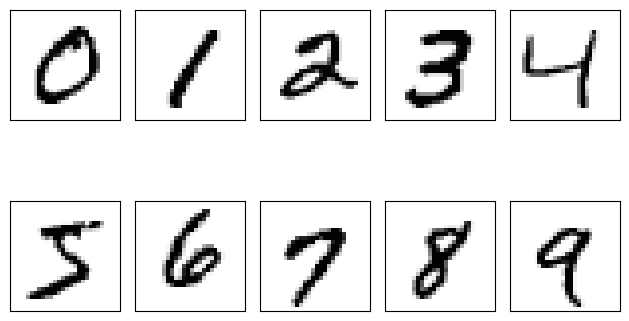

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Visualize 25 different versions of "7":

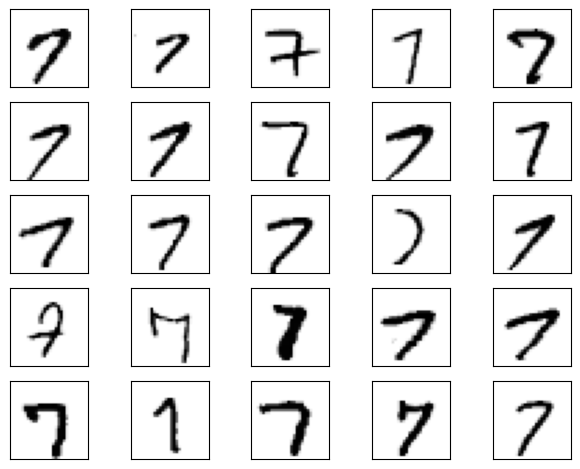

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Save data for later
https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html  
_savez_ uses a compressed (zip) NumPy array format.

In [10]:
import numpy as np

np.savez_compressed('data/mnist_scaled.npz', 
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)

In [11]:
mnist = np.load('data/mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

### Split and delete list

In [12]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 
                                    'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

## Implementing a multi-layer perceptron
- The following code is too large for slide presentation
- It contains parts that have not yet been introduced, e.g. backpropagation
    - We will revisit the code later, part by part
- Training the MLP on the MNIST data requires around 1.5 seconds per epoch on Liland's computer. Start calculations before going through the code if recommended 200 epochs are used (~5 minutes computing).

In [15]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch used in the stochastic gradient descent.
        (One gradient update per minibatch)
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation in output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ###################
                # Backpropagation #
                ###################
                # NB! Every sigma here is a small \delta in the text.
                #     Every delta her is a capital \Delta in the text. 

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

### Train on MNIST
- Training is expensive, especially for deep neural networks
    - Checking performance and tendencies of overfitting on a limited number of epochs and adjusting parameters can save time

In [16]:
# Around 1.5 seconds per epoch on Liland's computer
n_epochs = 200
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], y_train=y_train[:55000],
       X_valid=X_train[55000:], y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%  

### Visualize cost over epochs

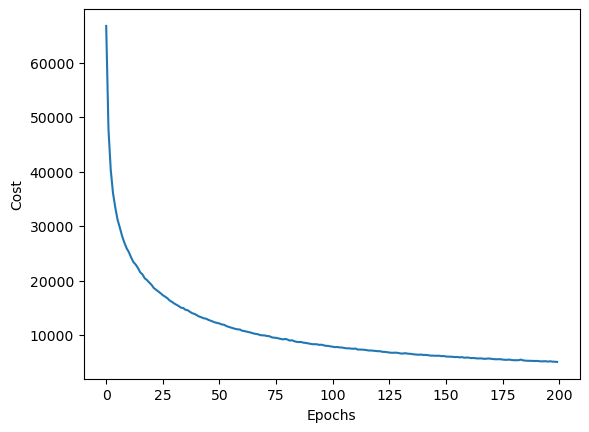

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

Still decreasing after 200 epochs

### Visualize accuracy

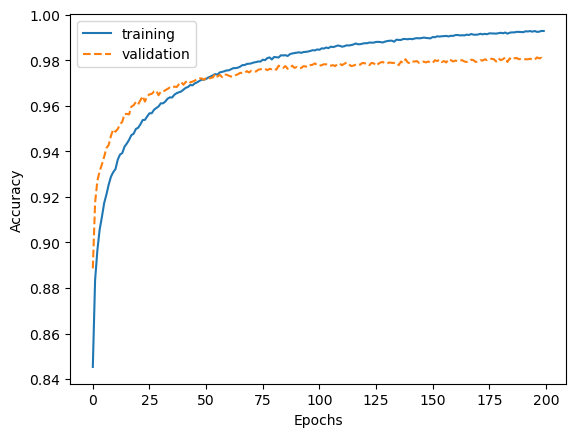

In [18]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.ylabel('Accuracy'); plt.xlabel('Epochs')
plt.legend(); plt.show()

Overfitting from ~50 epochs. Refit with higher regularization, e.g. L2 = 0.1?

### Test set performance

In [20]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float64) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


- Not bad for the autumn's first neural network. Still a little gap to the 98.7% reported in Wikipedia and 99.71% with pre-processing/data augmentation.  
- Tuning tricks include number of hidden units, degree of regularization, learning rate, adaptive learning rate, momentum learning and dropout. More on these later.

### Error analysis
- Mentioned with regard to regression in DAT200
- Assess some of the large errors or wrong classifications
- Get an idea of what can be improved
    - Tuning the algorithm
    - Pre-processing (image improvements/morphing)?
    - Extend training data with samples from EMNIST?
- Frown at impossible tasks

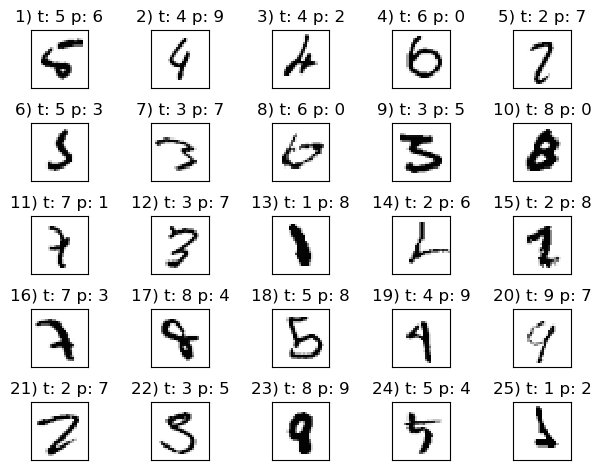

In [21]:
# Some misclassified images
miscl_img   = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab   = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([]); ax[0].set_yticks([])
plt.tight_layout()
plt.show()